<a href="https://colab.research.google.com/github/AhmedRefat10/CodeAlpha_Image_Recognition/blob/main/Sign_lang_digits_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sign-language-digits-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F7836%2F11071%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240513%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240513T202409Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0a4c67c03f215529eb4a1acdd283563499adc798fcbcc8735def3b7f8574197f2852c3f42f9c27c8ad4825a14726bfba6d9c111cbc78652e4ff785a7ca47531cfde21f2c531018b1e60abad4882075fd9aee7fefa042791e029bf0903dde44e62330bb00fc33e0560298aa6fead996c8a2f8bb351f36ded1ba399fd699c73143d2567dce9d63e6af3666abce7af4c535ef2075079d4ceeee0eea90136e59946c2f258edc616c0116c71cea944ccc449534fc592bc2a8f2ff236e3468c1f681a74cb553594ae354e5ab266e946f7379de333f83bc7210114145285a6026d027bc3b0eb304ea57051cee0556f3751cab05809c862e05d22b06d6cd3ee5e7c35eef'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import tensorflow.keras.layers as tfl
from keras.models import Sequential

# Load data

In [ ]:
x = np.load("/kaggle/input/sign-language-digits-dataset/X.npy")
y = np.load("/kaggle/input/sign-language-digits-dataset/Y.npy")

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

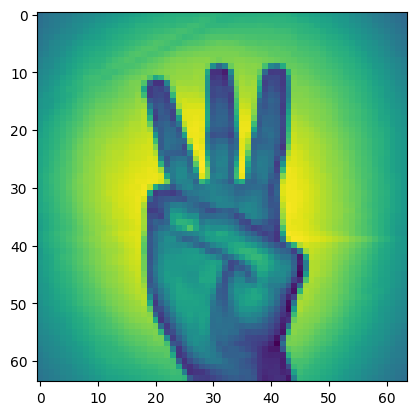

In [ ]:
plt.imshow(x[700]);
y[700]

# split data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1649, 64, 64), (1649, 10), (413, 64, 64), (413, 10))

In [ ]:
# Reshape
X_train = X_train.reshape(-1, 64, 64, 1)
X_test = X_test.reshape(-1, 64, 64, 1)

In [ ]:
X_train.shape, X_test.shape

((1649, 64, 64, 1), (413, 64, 64, 1))

# Model Using Functional API

In [ ]:
def conv_model(inp_shape):
    inp_img = tf.keras.Input(shape=inp_shape)

    C1 = tfl.Conv2D(8, (5,5), padding='same', activation='relu')(inp_img)
    P1 = tfl.MaxPool2D((8,8))(C1)
    Dr1 = tfl.Dropout(.25)(P1)

    C2 = tfl.Conv2D(16, (3,3), padding='same', activation='relu')(Dr1)
    P2 = tfl.MaxPool2D((2,2))(C2)
    Dr2 = tfl.Dropout(.25)(P2)

    C3 = tfl.Conv2D(32, (3,3), padding='same', activation='relu')(Dr2)
    P3 = tfl.MaxPool2D((2,2))(C3)
    Dr3 = tfl.Dropout(.25)(P3)

    C4 = tfl.Conv2D(64, (3,3), padding='same', activation='relu')(Dr3)
    P4 = tfl.MaxPool2D((2,2))(C4)
    Dr4 = tfl.Dropout(.25)(P4)

    F = tfl.Flatten()(Dr4)
    De1 = tfl.Dense(128, activation='relu')(F)
    De2 = tfl.Dense(64, activation='relu')(De1)
    outputs = tfl.Dense(10, activation='softmax')(De2)

    model = tf.keras.models.Model(inputs=inp_img, outputs=outputs)
    return model

In [ ]:
c_model = conv_model((64, 64, 1))
c_model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
c_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 8)      │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 2, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,738 (163.04 KB)

 Trainable params: 41,738 (163.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = c_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.1063 - loss: 2.3073 - val_accuracy: 0.0969 - val_loss: 2.3035
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.0934 - loss: 2.3033 - val_accuracy: 0.0775 - val_loss: 2.3059
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.1123 - loss: 2.3015 - val_accuracy: 0.0775 - val_loss: 2.3048
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.1071 - loss: 2.3018 - val_accuracy: 0.0823 - val_loss: 2.3019
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.1316 - loss: 2.2962 - val_accuracy: 0.2300 - val_loss: 2.2650
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.1887 - loss: 2.1859 - val_accuracy: 0.3366 - val_loss: 1.7251
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.3074 - loss: 1.7725 - val_accuracy: 0.4140 - val_loss: 1.4452
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.3726 - loss: 1.5793 - val_accuracy: 0.

/tmp/ipykernel_33/974158325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/tmp/ipykernel_33/974158325.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

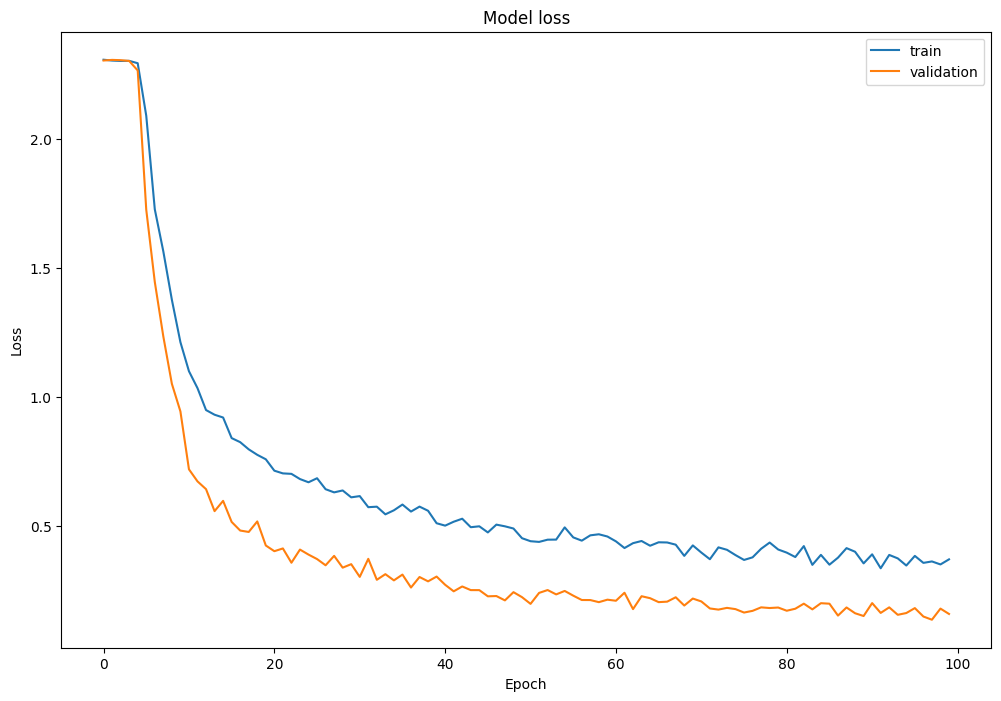

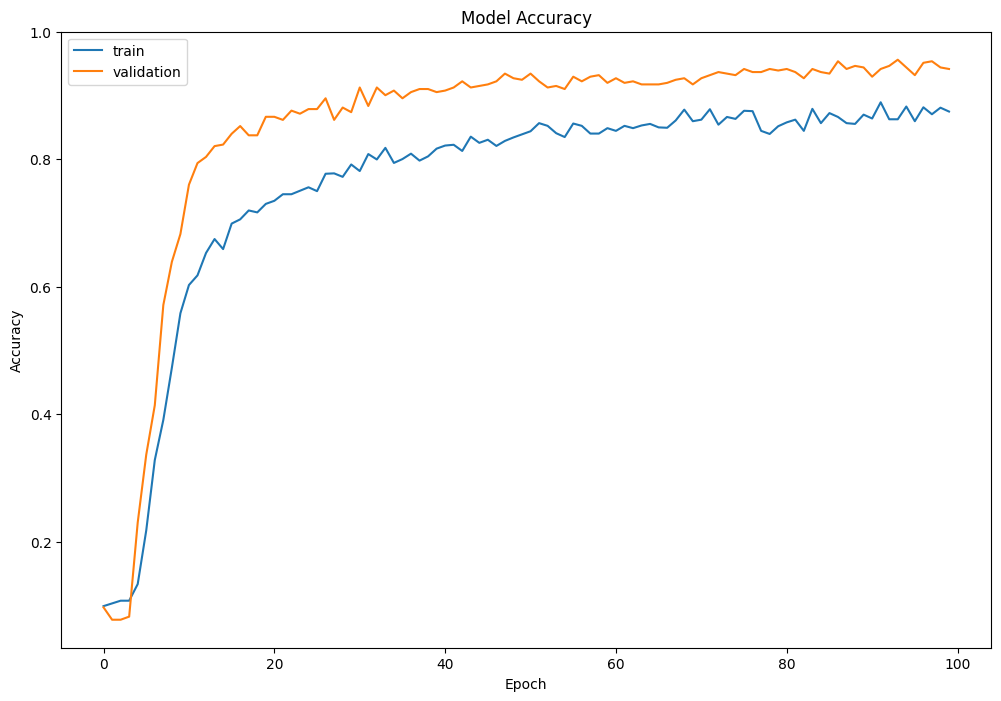

In [ ]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [ ]:
c_model.evaluate(X_test, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9373 - loss: 0.1802


[0.15775208175182343, 0.9418886303901672]

In [ ]:
# predict on dev set
y_pred = c_model.predict(X_test)
# convert predeictions to one hot vectors
y_pred_classes = np.argmax(y_pred, axis=1)
# convert true observations to one hot vectors
y_true = np.argmax(y_test, axis=1)
# compute confusion matrix
c_mtx = confusion_matrix(y_true, y_pred_classes)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [ ]:
c_mtx

array([[39,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0, 46,  0,  0,  0,  0,  1,  0,  1,  0],
       [ 0,  0, 46,  0,  0,  1,  2,  0,  1,  0],
       [ 0,  0,  1, 28,  0,  0,  2,  0,  4,  0],
       [ 0,  1,  0,  0, 31,  0,  0,  0,  0,  0],
       [ 2,  0,  4,  0,  0, 32,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0, 40,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 38,  0,  0],
       [ 0,  0,  1,  1,  0,  0,  0,  0, 43,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 46]])

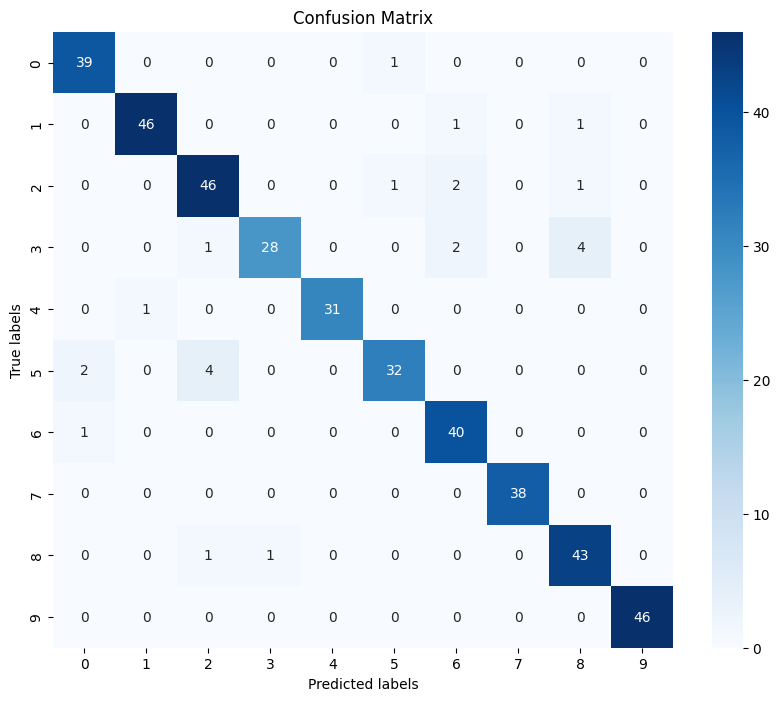

In [ ]:
# plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(c_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# predict on a single sample

In [ ]:
single_sample = c_model.predict(X_test[304].reshape(1, 64, 64, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [ ]:
single_sample

array([[6.4163282e-07, 1.9027549e-06, 2.1485803e-03, 1.2334546e-02,
        1.2044468e-03, 1.8742214e-05, 8.9638568e-05, 3.4040341e-04,
        9.8386109e-01, 3.9465022e-09]], dtype=float32)

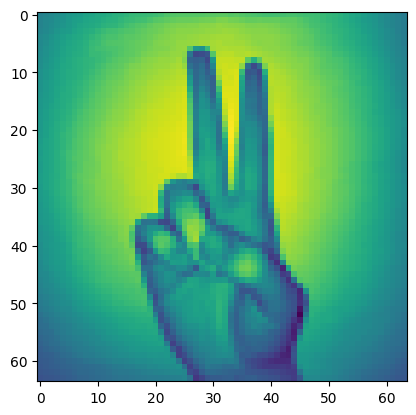

In [ ]:
plt.imshow(X_test[304]);

In [ ]:
int(y_test[304][(np.argmax(single_sample, axis=1))[0]]) == True

True

In [ ]:
np.argmax(single_sample, axis=1)

array([8])

In [ ]:
y_test[304]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])